Exercise 8
===
Let's create an autoencoder network that pretrains on MNIST images.

In [1]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Autosaving every 60 seconds
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

def he_normal_initialisation(n_inputs, n_outputs):
    stddev = np.power(2 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.truncated_normal((n_inputs, n_outputs), stddev=stddev)

def he_uniform_initialisation(n_inputs, n_outputs):
    r = np.power(6 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.random_uniform((n_inputs, n_outputs), -r, r)

def create_next_batch_fn(data, sequence_lengths, targets, batch_size):
    assert len(data) == len(sequence_lengths) and len(data) == len(targets)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        #print(current_batch)
        current_batch = (current_batch + batch_size) % len(data)
        return data[i:i+batch_size], sequence_lengths[i:i+batch_size], targets[i:i+batch_size]
    return next_batch

In [3]:
import math

input_spatial_size = 28
input_channels = 1
batch_size = 150

learning_rate = 0.01
n_input_neurons = input_spatial_size ** 2
n_hidden_neurons_layer1 = 120
n_hidden_neurons_layer2 = 75
n_hidden_neurons_layer3 = n_hidden_neurons_layer1
n_output_neurons = n_input_neurons
l2_reg = 0.0001

with tf.device("/gpu:0"):
    X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input")
    #var_X = tf.Variable(X, "input_variable", validate_shape=False)
    #assign_var_X = var_X.assign(X)
    #noisy_X = var_X + tf.random_normal(tf.shape(var_X), mean=0.1, stddev=0.1)
    noisy_X = X + tf.random_normal(tf.shape(X), mean=0.1, stddev=0.1)
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    hidden1 = my_dense_layer(noisy_X, n_hidden_neurons_layer1)
    hidden2 = my_dense_layer(hidden1, n_hidden_neurons_layer2)
    hidden3 = my_dense_layer(hidden2, n_hidden_neurons_layer3)
    # The output values are naturally in between 0 and 1 inclusive, so a sigmoid activation function is useful to squash the values.
    outputs = my_dense_layer(hidden3, n_output_neurons, activation=tf.nn.sigmoid)

    with tf.name_scope("loss"):
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
        #regularisation_loss = regularizer(weights1) + regularizer(weights2) \
        #    + regularizer(weights3) + regularizer(weights4)
        #regularisation_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = reconstruction_loss# + regularisation_loss

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_autoencoder_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_autoencoder_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 100
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)
#saver.restore(sess, interim_checkpoint_path)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run(training_op, feed_dict={X: X_batch})
        if batch_index % 10 == 0:
            l = sess.run(loss, feed_dict={X: X_batch})
            print("loss:", l)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            l = sess.run(loss, feed_dict={X: X_batch})
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
save_path = saver.save(sess, "./checkpoints/mnist_autoencoder_model_final.ckpt")

epoch 0
loss: 0.362132
loss: 0.0741558
loss: 0.0615648
loss: 0.0516678
loss: 0.0433914
loss: 0.0364206
loss: 0.0340882
loss: 0.0322527
loss: 0.0320844
loss: 0.0286523
loss: 0.0287898
loss: 0.0264409
loss: 0.0271292
loss: 0.0261803
loss: 0.0232848
loss: 0.0229305
loss: 0.022976
loss: 0.0225185
loss: 0.0219024
loss: 0.0190935
loss: 0.0206764
loss: 0.0208565
loss: 0.0187534
loss: 0.0183717
loss: 0.0191573
loss: 0.0182796
loss: 0.0195566
loss: 0.018971
loss: 0.0199149
loss: 0.0186884
loss: 0.0172076
loss: 0.0174171
loss: 0.0170007
loss: 0.0177924
loss: 0.0166502
loss: 0.015488
loss: 0.0163742
epoch 1
loss: 0.01745
loss: 0.016449
loss: 0.0159699
loss: 0.0156498
loss: 0.0160276
loss: 0.0168361
loss: 0.0155018
loss: 0.0150288
loss: 0.0163876
loss: 0.0163155
loss: 0.0137092
loss: 0.0146403
loss: 0.0140485
loss: 0.0155271
loss: 0.0160763
loss: 0.0160874
loss: 0.0146792
loss: 0.0151117
loss: 0.0150403
loss: 0.0141078
loss: 0.0140342
loss: 0.0154651
loss: 0.0143385
loss: 0.0143752
loss: 0.0140288

loss: 0.00775923
loss: 0.0075091
loss: 0.00765584
loss: 0.00853196
loss: 0.00705286
loss: 0.00751245
loss: 0.00742123
loss: 0.00809772
loss: 0.00774149
loss: 0.00852397
loss: 0.00821996
loss: 0.00789766
loss: 0.00771544
loss: 0.00769477
loss: 0.00745778
loss: 0.00774167
epoch 14
loss: 0.00762809
loss: 0.00763355
loss: 0.00818119
loss: 0.00765549
loss: 0.00772622
loss: 0.00790927
loss: 0.00792388
loss: 0.00760599
loss: 0.00731296
loss: 0.00772975
loss: 0.00742689
loss: 0.00823242
loss: 0.00770309
loss: 0.00791965
loss: 0.00804928
loss: 0.00848086
loss: 0.00685463
loss: 0.00755481
loss: 0.00812359
loss: 0.00796008
loss: 0.00744237
loss: 0.00688625
loss: 0.00745925
loss: 0.00792018
loss: 0.00769941
loss: 0.00816264
loss: 0.00781291
loss: 0.00819319
loss: 0.00729655
loss: 0.00838859
loss: 0.00806382
loss: 0.00738453
loss: 0.00725534
loss: 0.00780748
loss: 0.00806077
loss: 0.0080838
loss: 0.00741827
epoch 15
loss: 0.00757691
loss: 0.00797088
loss: 0.00781833
loss: 0.00818643
loss: 0.0074423

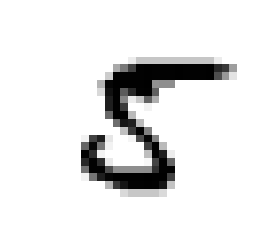

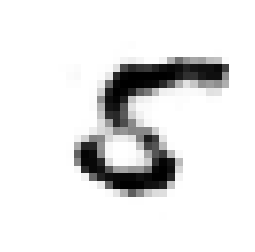

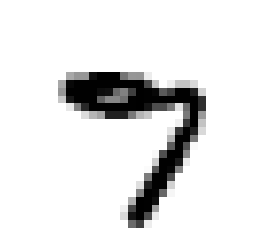

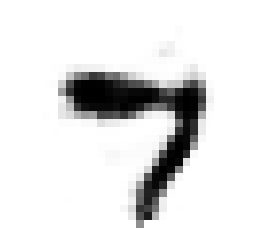

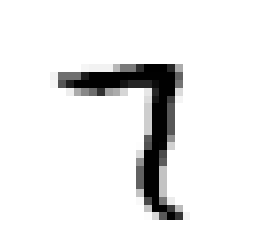

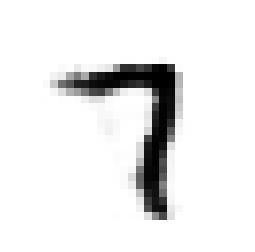

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()
    
visualisation_batch = mnist.train.images[:3]
o = sess.run([outputs], feed_dict={X: visualisation_batch})
o = np.array(o).reshape((-1, n_input_neurons))

image_shape = (input_spatial_size, input_spatial_size)
for input_data, output_data in zip(visualisation_batch, o):
    input_image = input_data.reshape(image_shape)
    show_image(input_image)
    output_image = output_data.reshape(image_shape)
    show_image(output_image)

Visualise the low-level featues.

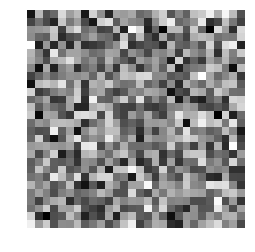

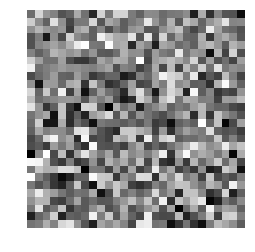

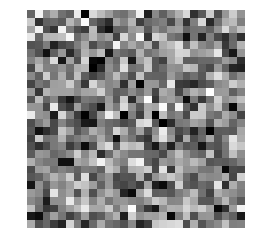

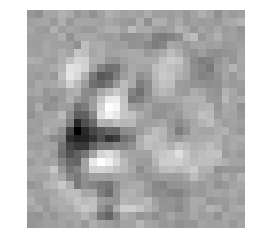

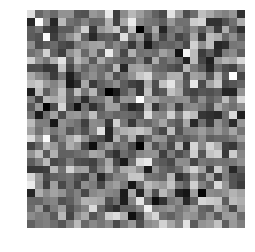

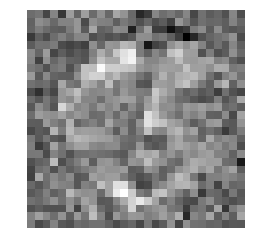

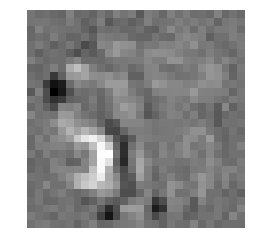

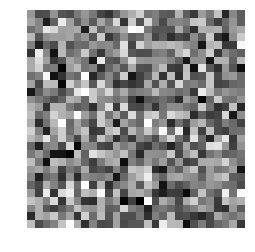

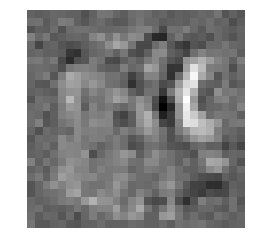

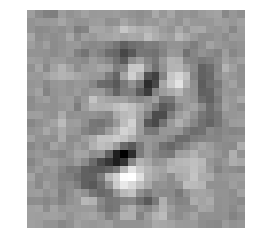

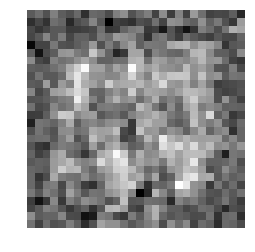

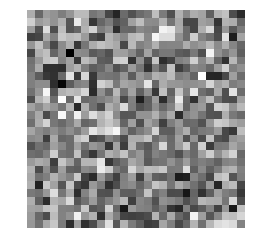

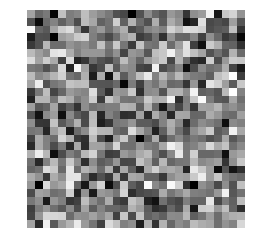

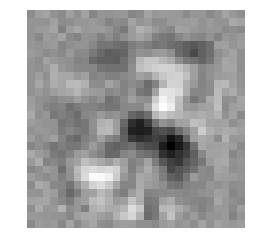

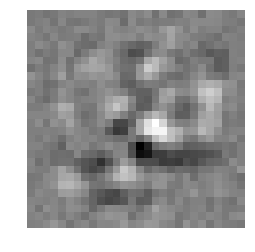

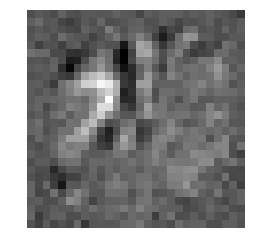

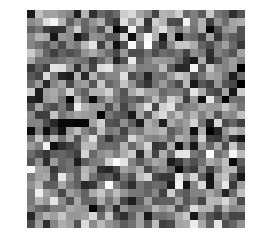

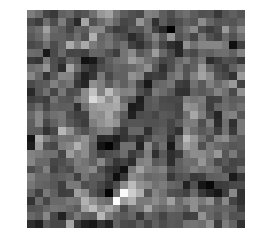

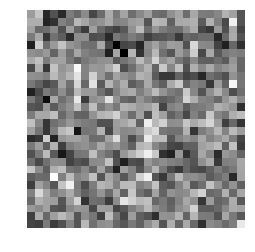

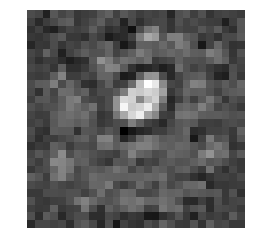

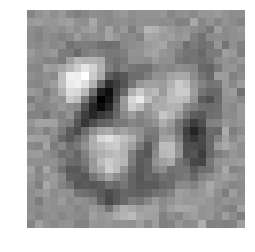

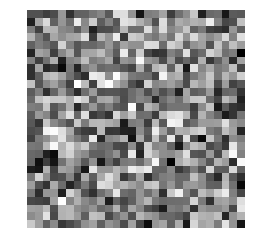

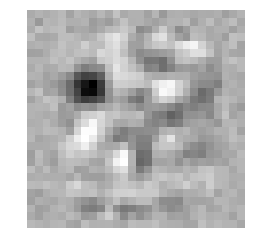

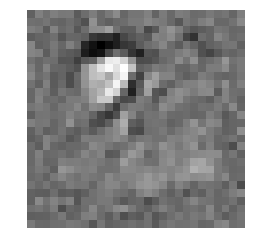

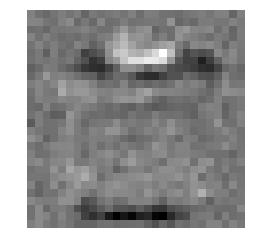

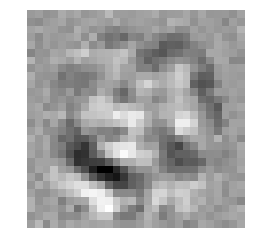

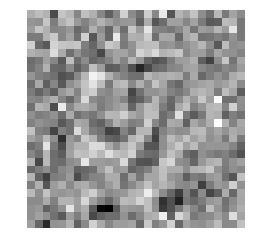

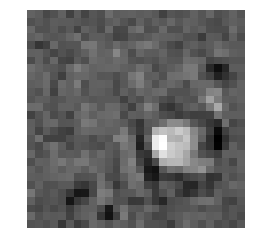

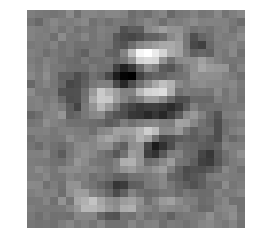

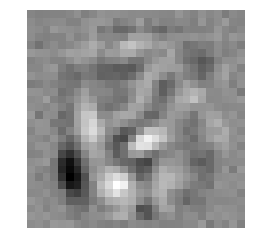

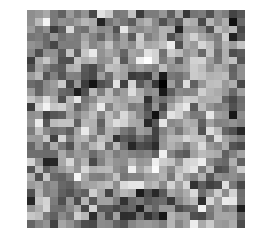

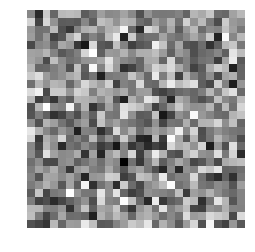

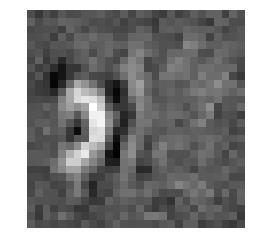

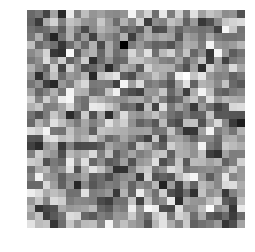

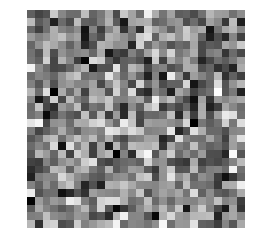

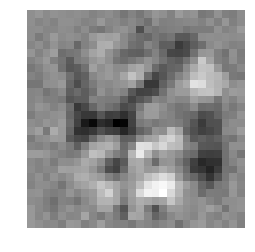

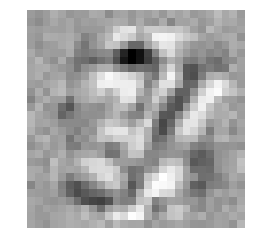

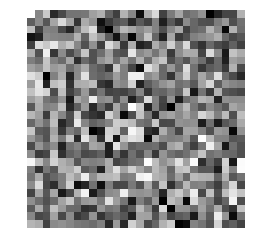

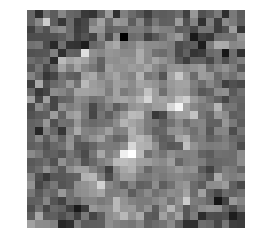

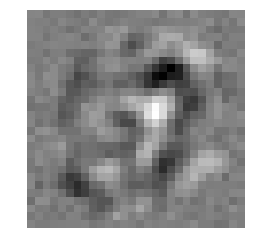

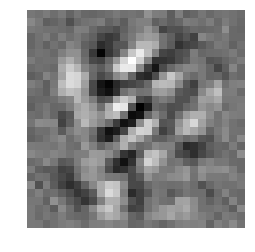

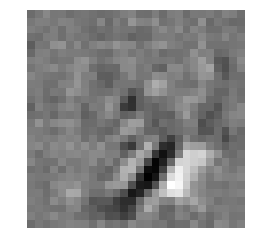

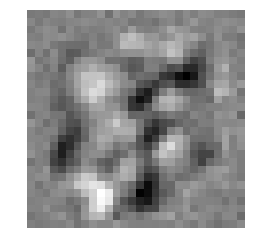

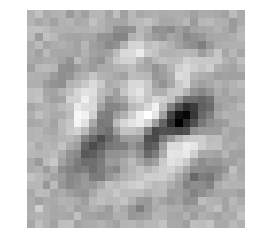

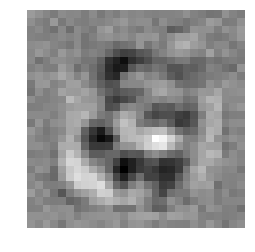

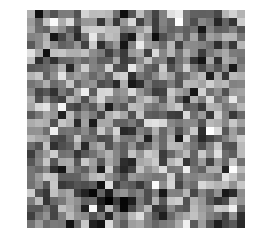

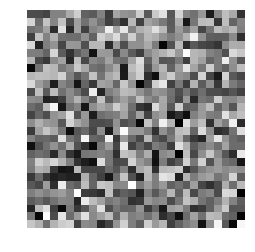

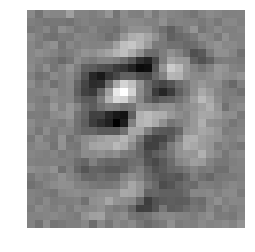

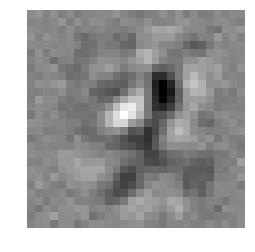

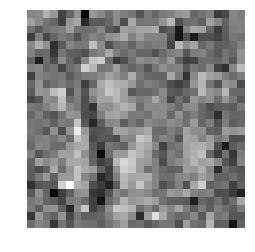

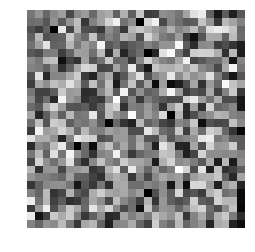

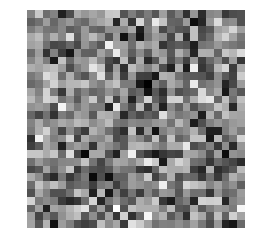

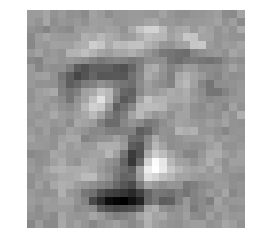

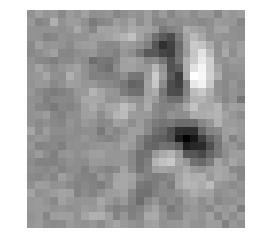

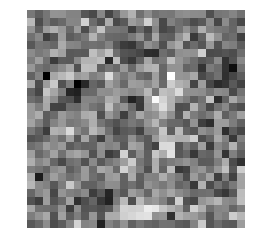

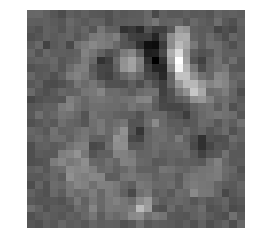

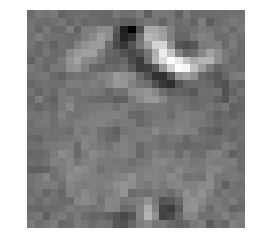

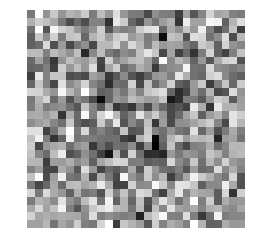

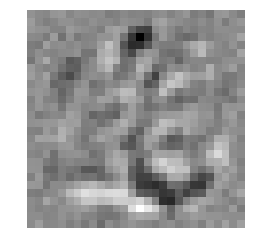

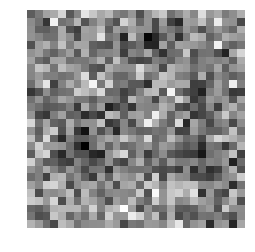

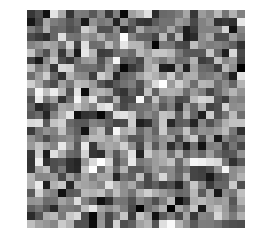

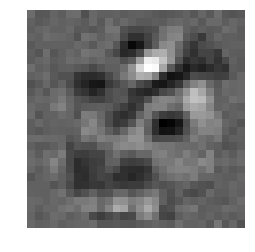

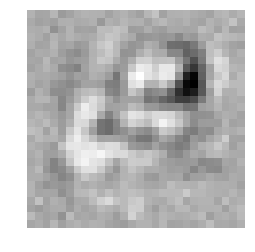

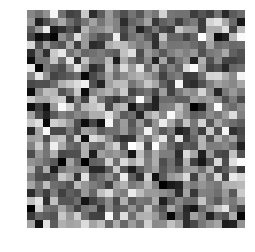

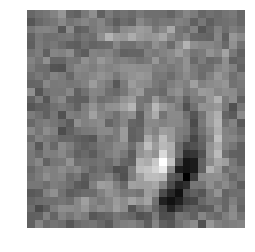

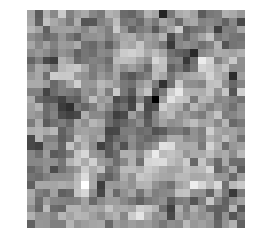

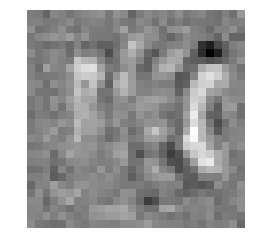

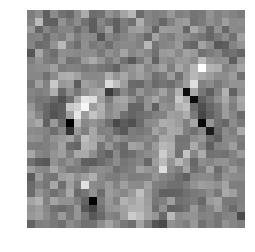

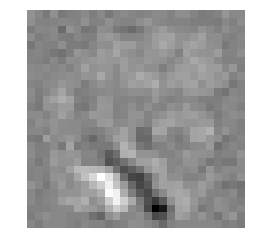

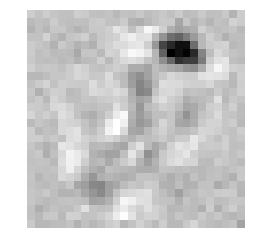

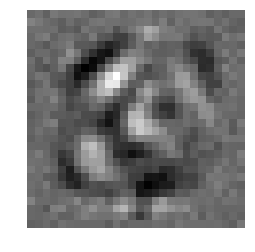

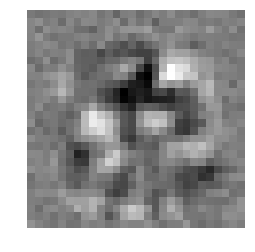

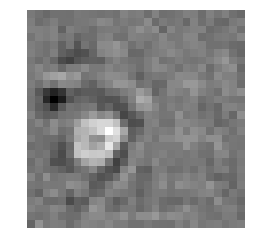

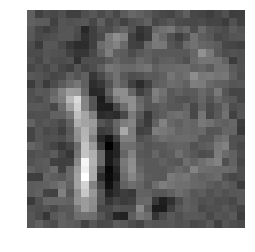

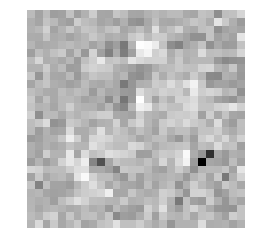

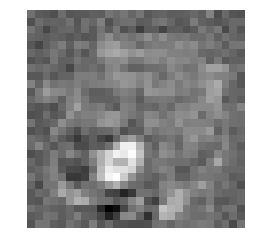

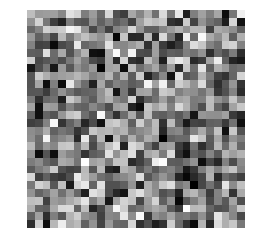

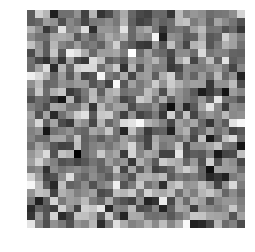

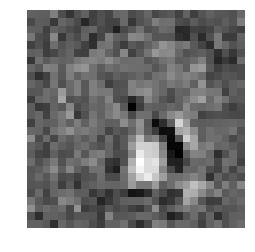

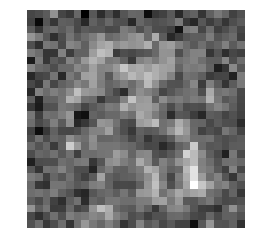

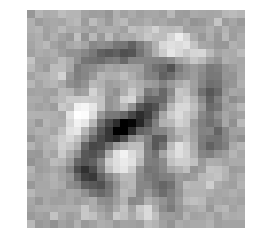

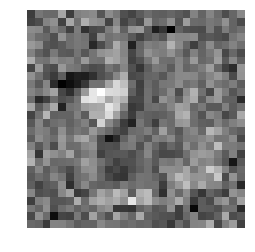

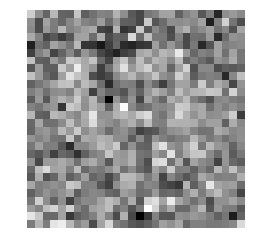

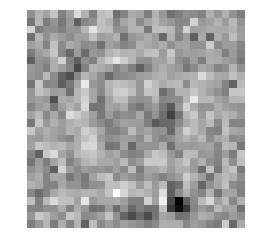

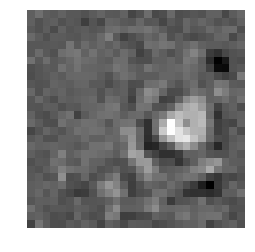

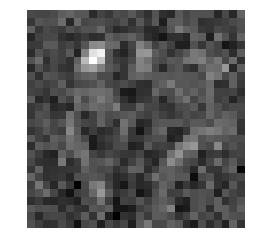

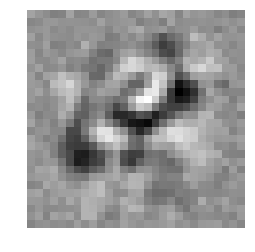

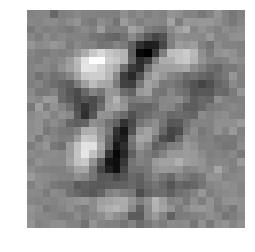

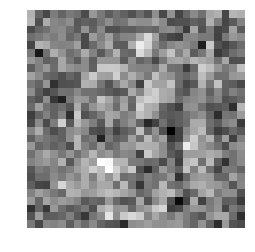

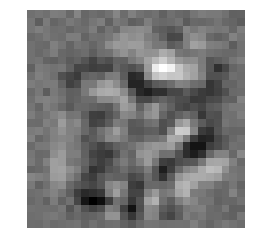

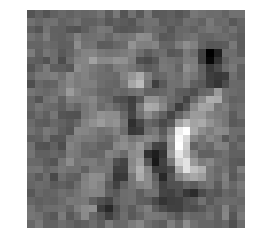

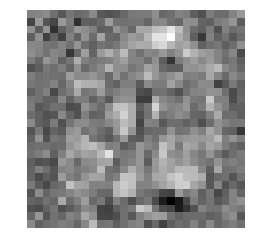

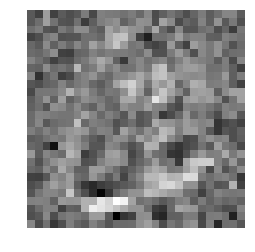

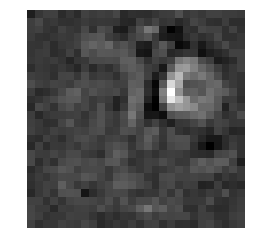

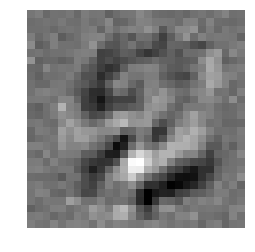

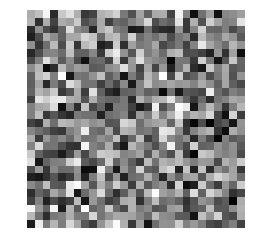

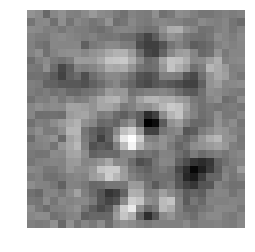

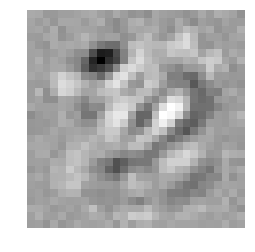

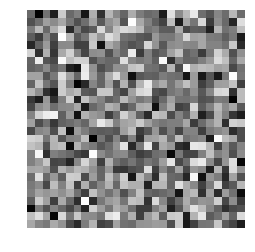

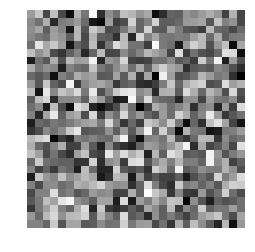

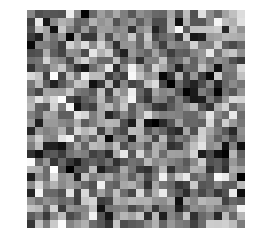

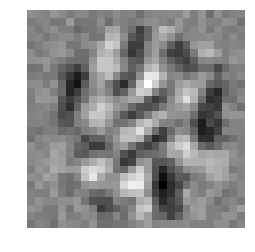

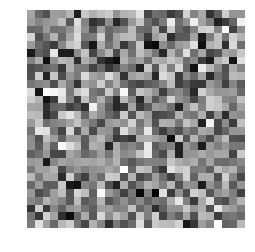

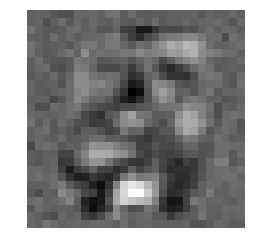

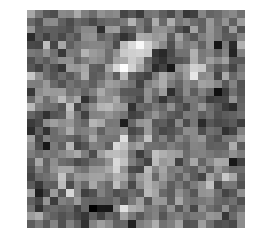

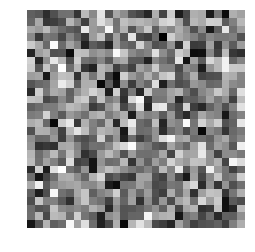

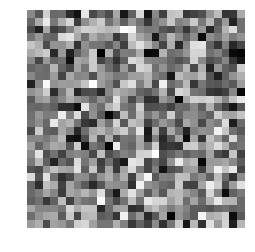

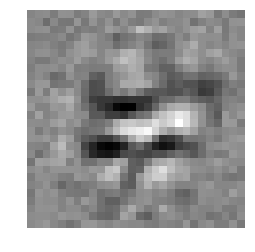

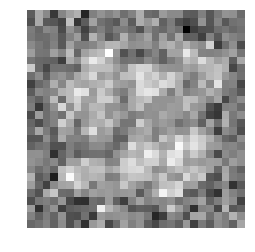

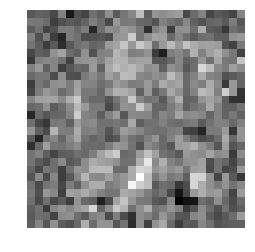

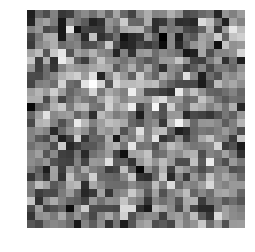

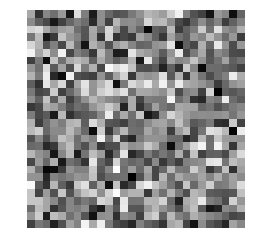

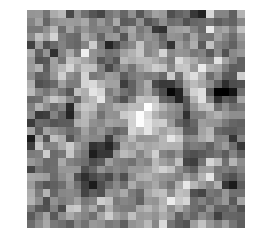

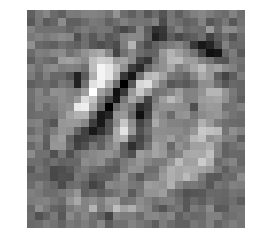

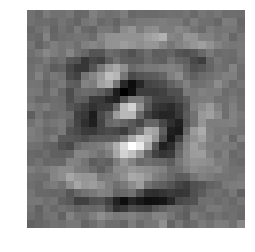

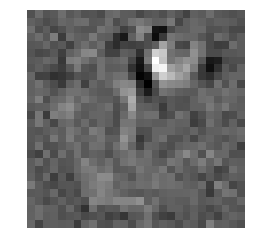

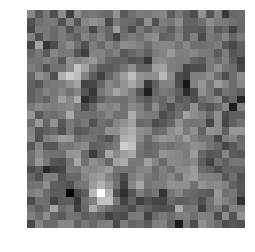

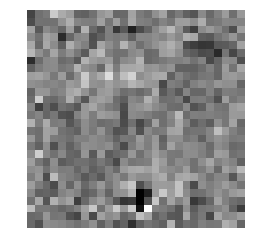

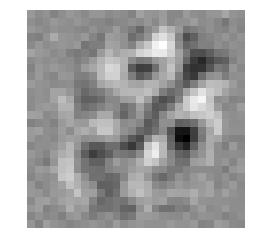

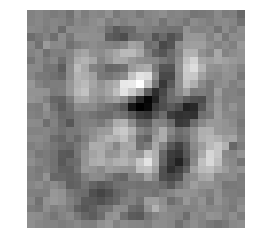

In [5]:
import os

def get_layer_weights(layer):
    # Attribution: https://stackoverflow.com/a/45372632/137996
    return tf.get_default_graph().get_tensor_by_name(os.path.split(layer.name)[0] + '/kernel:0')

with sess.as_default():
    # Go through each low lever neuron and turn its weights into an image.
    hidden1_weights = get_layer_weights(hidden1)
    for neuron_weights in np.transpose(hidden1_weights.eval()):
        show_image(neuron_weights.reshape(image_shape))

Interestingly, it appears that some neurons have random weights, which may be doing nothing. When other neurons are looking for specific shapes or even numbers like the number 3.

Visualise the images that activate each neuron the most in the coding layer.

**The follow code block doesn't work.**

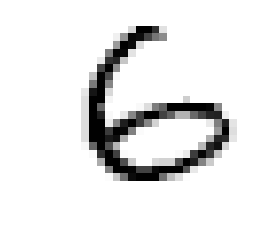

NotImplementedError: ('Trying to optimize unsupported type ', <tf.Tensor 'input:0' shape=(?, 784) dtype=float32>)

In [38]:
import random

with sess.as_default():
    for i in range(n_hidden_neurons_layer2):
        if i == 1: break
        rnd_image = mnist.train.images[random.randint(0, len(mnist.train.images))]
        show_image(rnd_image.reshape(image_shape))
        neuron_output = hidden2[:, i]
        altered_image = rnd_image.reshape((1, input_spatial_size ** 2))
        with tf.name_scope("visualisation_training"):
            visualisation_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            visualisation_training_op = optimizer.minimize(tf.pow(neuron_output, -1), var_list=[X])
            for j in range(10):
                _, altered_image = sess.run([visualisation_training_op, X], feed_dict={X: X_batch})
            show_image(altered_image.reshape(image_shape))

Build a classification deep neural network, reuse the lower layers of the autoencoder.

In [6]:
clf_n_hidden_neurons_layer3 = 200

with tf.device("/gpu:0"):
    y = tf.placeholder(tf.int32, shape=(None), name="labels")
    
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    clf_hidden3 = my_dense_layer(hidden2, clf_n_hidden_neurons_layer3)
    logits = my_dense_layer(clf_hidden3, n_output_neurons)

    with tf.name_scope("loss"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        clf_loss = tf.reduce_mean(cross_entropy, name="loss")

    with tf.name_scope("training"):
        clf_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        clf_training_op = optimizer.minimize(clf_loss)

with tf.name_scope("eval"):
    k = 1
    correctness = tf.nn.in_top_k(logits, y, k)
    accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32)) * 100.0
    
clf_init = tf.global_variables_initializer()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

epochs = 6
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

saver = tf.train.Saver()
early_stopping_checkpoint_path = "./checkpoints/mnist_model_early_stopping.ckpt"

sess.run(clf_init)

def create_next_batch_fn(images, labels, batch_size):
    assert len(images) == len(labels)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        #print(current_batch)
        current_batch = (current_batch + batch_size) % len(images)
        return images[i:i+batch_size], labels[i:i+batch_size]
    return next_batch

training_size = int(len(mnist.train.images) / 10)
print("training dataset size", training_size)
create_next_batch = create_next_batch_fn(
    mnist.train.images[:training_size],
    mnist.train.labels[:training_size],
    batch_size)


best_validation_acc = 0.0
best_validation_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        X_batch, y_batch = create_next_batch()
        t, l, ta = sess.run([clf_training_op, clf_loss, accuracy], feed_dict={X: X_batch, y: y_batch})
        #l = sess.run(clf_loss, feed_dict={X: X_batch, y: y_batch})
        if batch_index % 10 == 0:
            print("loss:", l, "training accuracy:", ta)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            validation_acc = sess.run(accuracy, feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print("validation accuracy", validation_acc)
            if validation_acc > best_validation_acc:
                saver.save(sess, early_stopping_checkpoint_path)
                best_validation_acc = validation_acc
                best_validation_step = step
            elif step >= (best_validation_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch)
                break
    else:
        continue
    break
saver.restore(sess, early_stopping_checkpoint_path)
test_acc = sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels})
print(">>>>>>>>>> test dataset accuracy:", test_acc)

training dataset size 5500
epoch 0
loss: 6.93623 training accuracy: 0.0
validation accuracy 9.6
loss: 4.92403 training accuracy: 24.6667
loss: 4.20577 training accuracy: 39.3333
loss: 3.84681 training accuracy: 34.0
loss: 1.87096 training accuracy: 58.0
loss: 0.802219 training accuracy: 71.3333
loss: 0.551768 training accuracy: 82.0
loss: 0.574122 training accuracy: 85.3333
loss: 0.24541 training accuracy: 91.3333
loss: 0.348258 training accuracy: 86.0
validation accuracy 87.48
loss: 0.513905 training accuracy: 85.3333
loss: 0.332441 training accuracy: 90.6667
loss: 0.320497 training accuracy: 90.0
loss: 0.296152 training accuracy: 92.0
loss: 0.424575 training accuracy: 90.0
loss: 0.27289 training accuracy: 91.3333
loss: 0.331344 training accuracy: 89.3333
loss: 0.373177 training accuracy: 85.3333
loss: 0.291067 training accuracy: 92.0
validation accuracy 90.22
loss: 0.159867 training accuracy: 96.0
loss: 0.112362 training accuracy: 96.0
loss: 0.228147 training accuracy: 94.0
loss: 0.2

loss: 0.00294235 training accuracy: 100.0
loss: 0.0747851 training accuracy: 98.0
loss: 0.073572 training accuracy: 98.6667
loss: 0.000340627 training accuracy: 100.0
loss: 0.0430393 training accuracy: 98.6667
loss: 0.00220318 training accuracy: 100.0
loss: 0.000697744 training accuracy: 100.0
loss: 0.0729572 training accuracy: 98.0
loss: 0.107969 training accuracy: 96.6667
validation accuracy 94.66
loss: 0.182559 training accuracy: 96.0
loss: 0.0182892 training accuracy: 99.3333
loss: 0.0832615 training accuracy: 97.3333
loss: 0.0920949 training accuracy: 97.3333
loss: 0.107957 training accuracy: 96.6667
loss: 0.023404 training accuracy: 98.6667
loss: 0.0787211 training accuracy: 96.0
loss: 0.104357 training accuracy: 97.3333
loss: 0.0172056 training accuracy: 98.6667
validation accuracy 93.96
loss: 0.0275568 training accuracy: 99.3333
loss: 0.0394081 training accuracy: 98.6667
loss: 0.0873197 training accuracy: 98.6667
loss: 0.0403751 training accuracy: 98.6667
loss: 0.0214922 traini

Creating an ok-performing autoencoder and using transfer learning to create a classifier using 10% of the training data resulted in a test dataset accuracy of test dataset accuracy: 94.49% which is 1.98% less than a model trained from scratch on the entire dataset (with 96.47% test accuracy). This isn't too bad considering that the training dataset is 10% of the size of the comparison model's training setup.

Exercise 9
===

Create a stacked autoencoder:
input -> hidden 1 -> hidden 2 -> coding -> hidden 4 -> hidden 5 -> output

In [2]:
import math

input_spatial_size = 28
input_channels = 1
batch_size = 80

learning_rate = 0.005
n_input_neurons = input_spatial_size ** 2
n_hidden_neurons_layer1 = 100
n_hidden_neurons_layer2 = 70
n_hidden_neurons_layer3 = 30 # coding layer
n_hidden_neurons_layer4 = n_hidden_neurons_layer2
n_hidden_neurons_layer5 = n_hidden_neurons_layer1
n_output_neurons = n_input_neurons
l2_reg = 0.0001

with tf.device("/gpu:0"):
    X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input")
    noisy_X = X + tf.random_normal(tf.shape(X), mean=0.1, stddev=0.1)
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    hidden1 = my_dense_layer(noisy_X, n_hidden_neurons_layer1)
    hidden2 = my_dense_layer(hidden1, n_hidden_neurons_layer2)
    # Add noise to the coding input to force the Model to input large values to "drown out" the noise.
    coding_input = hidden2 + tf.random_normal(tf.shape(hidden2), mean=0.0, stddev=0.3)
    codings = my_dense_layer(coding_input, n_hidden_neurons_layer3, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer())
    hidden4 = my_dense_layer(codings, n_hidden_neurons_layer4)
    hidden5 = my_dense_layer(hidden4, n_hidden_neurons_layer5)
    # The output values are naturally in between 0 and 1 inclusive, so a sigmoid activation function is useful to squash the values.
    outputs = my_dense_layer(hidden5, n_output_neurons, activation=tf.nn.sigmoid, kernel_initializer=None)

    with tf.name_scope("loss"):
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
        #regularisation_loss = regularizer(weights1) + regularizer(weights2) \
        #    + regularizer(weights3) + regularizer(weights4)
        #regularisation_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = reconstruction_loss# + regularisation_loss

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_semantic_hashing_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_semantic_hashing_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 100
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)
#saver.restore(sess, interim_checkpoint_path)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run([training_op], feed_dict={X: X_batch})
        l = sess.run(loss, feed_dict={X: X_batch})
        if batch_index % 10 == 0: print("loss:", l)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
print("total training loss:", sess.run(reconstruction_loss, feed_dict={X: mnist.train.images}))
save_path = saver.save(sess, "./checkpoints/mnist_semantic_hashing_model_final.ckpt")

epoch 0
loss: 0.208532
loss: 0.0658971
loss: 0.067109
loss: 0.0661827
loss: 0.0681225
loss: 0.065722
loss: 0.0602559
loss: 0.057429
loss: 0.0570425
loss: 0.0636233
loss: 0.0606962
loss: 0.0583394
loss: 0.0568587
loss: 0.0548498
loss: 0.0578571
loss: 0.0592303
loss: 0.053342
loss: 0.0533241
loss: 0.0541217
loss: 0.0539831
loss: 0.0508991
loss: 0.054665
loss: 0.0484685
loss: 0.0508354
loss: 0.0482044
loss: 0.0459017
loss: 0.0448525
loss: 0.0473338
loss: 0.0456908
loss: 0.046028
loss: 0.0458721
loss: 0.0416661
loss: 0.0378321
loss: 0.037329
loss: 0.0372547
loss: 0.0401888
loss: 0.0387036
loss: 0.0364485
loss: 0.0351503
loss: 0.0337469
loss: 0.0324119
loss: 0.0313613
loss: 0.0312865
loss: 0.0300455
loss: 0.0314104
loss: 0.031024
loss: 0.0312505
loss: 0.0294577
loss: 0.034678
loss: 0.030863
loss: 0.0290039
loss: 0.0300536
loss: 0.0306795
loss: 0.0287688
loss: 0.0305513
loss: 0.0321146
loss: 0.0298269
loss: 0.0256978
loss: 0.0267119
loss: 0.0260052
loss: 0.0257869
loss: 0.0275808
loss: 0.025

loss: 0.0108398
loss: 0.0113667
loss: 0.0105035
loss: 0.0114153
loss: 0.0120459
loss: 0.0122092
loss: 0.0110016
loss: 0.0115341
loss: 0.0115707
loss: 0.010972
loss: 0.0108053
loss: 0.0118837
loss: 0.0126141
loss: 0.0112145
loss: 0.0111467
loss: 0.0104893
loss: 0.0115629
loss: 0.0116533
loss: 0.0121672
loss: 0.0107023
loss: 0.0105067
loss: 0.0124114
loss: 0.0112814
loss: 0.0110551
loss: 0.0105727
loss: 0.0109004
loss: 0.01233
loss: 0.011289
loss: 0.0119011
loss: 0.0116009
loss: 0.0128085
loss: 0.00942425
loss: 0.0116114
loss: 0.010036
loss: 0.0122531
loss: 0.011467
loss: 0.0122558
loss: 0.0106717
loss: 0.0111394
epoch 8
loss: 0.0112416
loss: 0.0105298
loss: 0.0114395
loss: 0.0115928
loss: 0.0108518
loss: 0.0115106
loss: 0.0113796
loss: 0.0108054
loss: 0.0120226
loss: 0.0108389
loss: 0.0117412
loss: 0.0125019
loss: 0.011067
loss: 0.0112972
loss: 0.0107205
loss: 0.0111205
loss: 0.0111196
loss: 0.0100559
loss: 0.0115434
loss: 0.0125614
loss: 0.0110264
loss: 0.0113452
loss: 0.0117246
loss: 

Adding noise to the coding layer's input increased the loss of the model, but does squash the coding values to 0 and 1 more than before, making the hash more useful.

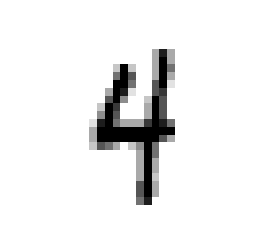

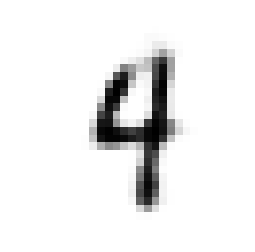

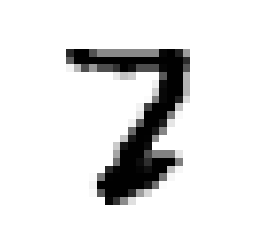

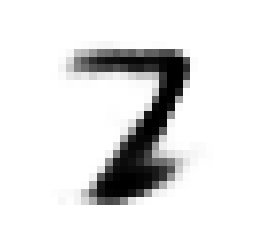

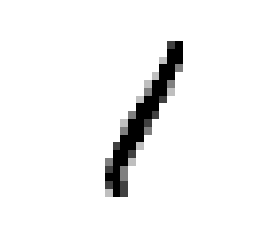

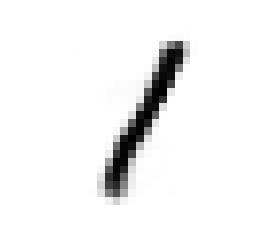

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()
    
visualisation_batch = mnist.train.images[:3]
o = sess.run([outputs], feed_dict={X: visualisation_batch})
o = np.array(o).reshape((-1, n_input_neurons))

image_shape = (input_spatial_size, input_spatial_size)
for input_data, output_data in zip(visualisation_batch, o):
    input_image = input_data.reshape(image_shape)
    show_image(input_image)
    output_image = output_data.reshape(image_shape)
    show_image(output_image)

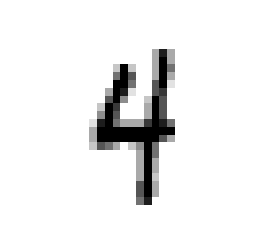

[1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0]


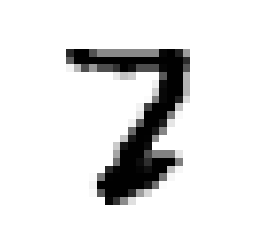

[0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1]


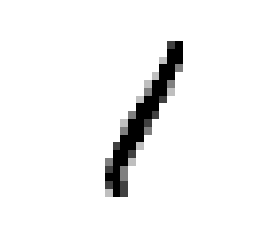

[0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1]


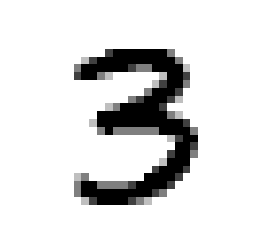

[0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1]


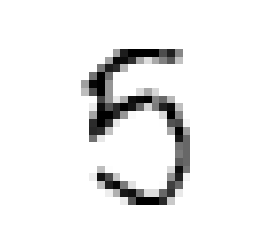

[0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1]


In [9]:
def coding_to_bit_hash(coding):
    return np.array(list(map(lambda a: int(round(a)), coding)))

images = mnist.train.images[:5]
codings_output = sess.run(codings, feed_dict={X: images})
for i in range(len(images)):
    show_image(images[i].reshape(image_shape))
    coding = codings_output[i]
    #print(coding)
    print(coding_to_bit_hash(coding))

In [10]:
def bit_hash_to_int(bit_hash):
    bit_str = "".join(map(lambda a: str(a), bit_hash))
    return int(bit_str, 2)

In [11]:
codings_output = sess.run(codings, feed_dict={X: mnist.train.images})

def create_matching_dictionary(codings, labels):
    coding_int_to_labels = {}
    for i in range(len(codings)):
        label = labels[i]
        coding_int = bit_hash_to_int(coding_to_bit_hash(codings_output[i]))
        if not coding_int in coding_int_to_labels:
            coding_int_to_labels[coding_int] = []
        coding_int_to_labels[coding_int].append(label)
    return coding_int_to_labels

coding_int_to_labels = create_matching_dictionary(codings_output, mnist.train.labels)

In [12]:
for hash_int, labels in coding_int_to_labels.items():
    if len(labels) > 1:
        print(labels)

[7, 7]
[3, 3]
[5, 5]
[5, 5]
[4, 4]
[7, 7]
[4, 4, 4]
[5, 5, 5]
[7, 7, 7, 7]
[5, 5]
[5, 5]
[8, 8]
[3, 3]
[1, 1]
[6, 6]
[1, 1, 1]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[5, 6, 6]
[1, 1]
[6, 6]
[9, 9, 9, 9, 9]
[3, 3, 3, 3]
[3, 3]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2, 0, 0]
[5, 5]
[7, 7]
[0, 0, 0]
[9, 9]
[1, 1, 1, 1, 1]
[7, 7, 7]
[2, 2]
[5, 5]
[7, 7, 7, 7, 7]
[7, 7, 7, 7]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0]
[0, 0]
[7, 7, 7]
[0, 0, 0, 0, 0]
[7, 7]
[0, 0]
[7, 7]
[4, 4]
[3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[9, 9, 9]
[4, 4]
[4, 4]
[6, 6]
[1, 1]
[1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[9, 9]
[3, 3]
[7, 7]
[7, 7]
[9, 9]
[3, 3, 3]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[9, 9]
[0, 0, 0, 0, 0]
[9, 9, 9, 9]
[9, 9]
[1, 

[5, 8]
[7, 7, 7, 7, 7]
[8, 8]
[9, 9]
[4, 4]
[7, 7, 7]
[1, 1]
[5, 5]
[9, 9]
[5, 5, 5]
[1, 1]
[9, 9]
[3, 3]
[1, 1]
[7, 7, 7]
[0, 0, 0, 0]
[1, 1]
[1, 1]
[9, 9]
[3, 3]
[7, 7, 7, 7, 7, 7, 7]
[1, 1]
[1, 1]
[6, 6]
[9, 4, 4, 9]
[6, 6, 6, 6, 6]
[1, 1, 1, 1]
[8, 9]
[4, 4, 4, 4]
[7, 7]
[6, 6, 6]
[5, 5]
[4, 4]
[8, 8]
[7, 7]
[4, 4]
[6, 6]
[7, 7]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2]
[2, 2]
[7, 7]
[3, 3]
[0, 0, 0]
[5, 5, 5]
[7, 7, 7]
[8, 8]
[1, 1, 1, 1, 1]
[2, 2, 2]
[5, 5]
[4, 4]
[9, 9]
[9, 9]
[6, 6, 6]
[6, 6]
[2, 2]
[4, 4]
[6, 6]
[4, 4]
[4, 4]
[6, 6]
[3, 3]
[6, 4]
[2, 3]
[1, 1, 1, 1, 1, 1, 1]
[8, 8, 8]
[0, 0]
[2, 2]
[0, 0]
[1, 1]
[0, 0, 0]
[8, 8, 8]
[8, 8]
[7, 7]
[1, 1, 1]
[0, 0, 0]
[7, 7, 7]
[6, 6]
[6, 6]
[5, 5]
[6, 6]
[3, 3]
[6, 6]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[4, 4]
[2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[4, 4]
[3, 3, 3]
[1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [13]:
non_unique_hashes = len(mnist.train.images) - len(coding_int_to_labels)
print("Number of images that share a hash:", non_unique_hashes)
print("Percentage of images that share a hash:", non_unique_hashes / len(mnist.train.images) * 100.0)
n_invalid_hash_sets = 0
for hash_int, labels in coding_int_to_labels.items():
    if len(set(labels)) > 1:
        n_invalid_hash_sets += 1
print("Number of invalid hash sets:", n_invalid_hash_sets)
print("Percentage of invalid hash sets:", n_invalid_hash_sets / non_unique_hashes * 100.0)

Number of images that share a hash: 11230
Percentage of images that share a hash: 20.418181818181818
Number of invalid hash sets: 197
Percentage of invalid hash sets: 1.7542297417631345


The code could be changed so that more images share hashes, but the invalid hash set rate of 1.6% is very low and is sufficient.

In [25]:
# Attribution: https://stackoverflow.com/a/13849249/137996
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in degrees between vectors 'v1' and 'v2'::
    """
    if np.array_equal(v1, v2):
        return 0.0
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [30]:
def find_biggest_angle_between_like_labels(codings, labels):
    labels_to_bit_hashes = {}
    for i in range(len(codings)):
        bit_hash = coding_to_bit_hash(codings_output[i])
        label = labels[i]
        if not label in labels_to_bit_hashes:
            labels_to_bit_hashes[label] = []
        labels_to_bit_hashes[label].append(bit_hash)
        
    for label, bit_hashes in labels_to_bit_hashes.items():
        biggest_angle = 0.0
        for i in range(len(bit_hashes)):
            outer_bit_hash = bit_hashes[i]
            for j in range(i, len(bit_hashes) - i ):
                inner_bit_hash = bit_hashes[j]
                angle = angle_between(outer_bit_hash, inner_bit_hash)
                if angle > biggest_angle:
                    biggest_angle = angle
        print("Label:", label, "biggest angle:", biggest_angle)
        
find_biggest_angle_between_like_labels(codings_output, mnist.train.labels)

Label: 0 biggest angle: 74.3911185583
Label: 1 biggest angle: 73.897886248
Label: 2 biggest angle: 75.0367825667
Label: 3 biggest angle: 74.5339900466
Label: 4 biggest angle: 75.5224878141
Label: 5 biggest angle: 75.2552163321
Label: 6 biggest angle: 74.4986404331
Label: 7 biggest angle: 74.5339900466
Label: 8 biggest angle: 74.9725674501
Label: 9 biggest angle: 74.9725674501


All images of the same label can have a vector angle of up to ~75 degrees difference from each other.

Exercise 10
===
Create a Variational Autoencode to generate images

In [33]:
import math

input_spatial_size = 28
input_channels = 1
batch_size = 150

learning_rate = 0.01
n_input_neurons = input_spatial_size ** 2
n_hidden_neurons_layer1 = 120
n_hidden_neurons_layer2 = 75
n_hidden_neurons_layer3 = n_hidden_neurons_layer1
n_output_neurons = n_input_neurons
l2_reg = 0.0001

with tf.device("/gpu:0"):
    X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input")
    #var_X = tf.Variable(X, "input_variable", validate_shape=False)
    #assign_var_X = var_X.assign(X)
    #noisy_X = var_X + tf.random_normal(tf.shape(var_X), mean=0.1, stddev=0.1)
    noisy_X = X + tf.random_normal(tf.shape(X), mean=0.1, stddev=0.1)
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    hidden1 = my_dense_layer(noisy_X, n_hidden_neurons_layer1)
    mew_coding = my_dense_layer(hidden1, n_hidden_neurons_layer2)
    sigma_coding = my_dense_layer(hidden1, 1)
    variational_noise = tf.random_normal(tf.shape(mew_coding))
    coding_layer = mew_coding + variational_noise * sigma_coding
    hidden3 = my_dense_layer(coding_layer, n_hidden_neurons_layer3)
    # The output values are naturally in between 0 and 1 inclusive, so a sigmoid activation function is useful to squash the values.
    outputs = my_dense_layer(hidden3, n_output_neurons, activation=tf.nn.sigmoid)

    with tf.name_scope("loss"):
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
        #regularisation_loss = regularizer(weights1) + regularizer(weights2) \
        #    + regularizer(weights3) + regularizer(weights4)
        #regularisation_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        eps = 1e-10
        latent_loss = 0.5 * tf.reduce_sum(
            tf.square(sigma_coding)
            + tf.square(mew_coding)
            - 1
            - tf.log(eps + tf.square(sigma_coding))
        )
        loss = reconstruction_loss# + regularisation_loss

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_variational_autoencoder_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_variational_autoencoder_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 100
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)
#saver.restore(sess, interim_checkpoint_path)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run(training_op, feed_dict={X: X_batch})
        if batch_index % 10 == 0:
            l = sess.run(loss, feed_dict={X: X_batch})
            print("loss:", l)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            l = sess.run(loss, feed_dict={X: X_batch})
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
print("total training loss:", sess.run(reconstruction_loss, feed_dict={X: mnist.train.images}))
save_path = saver.save(sess, "./checkpoints/mnist_variational_autoencoder_model_final.ckpt")

epoch 0
loss: 0.335742
loss: 0.0945491
loss: 0.0834818
loss: 0.0734763
loss: 0.0592687
loss: 0.0535438
loss: 0.0513056
loss: 0.0454094
loss: 0.0415799
loss: 0.0398545
loss: 0.0383194
loss: 0.0352546
loss: 0.0332019
loss: 0.0327691
loss: 0.0337151
loss: 0.0316926
loss: 0.0312461
loss: 0.0296932
loss: 0.026995
loss: 0.0263352
loss: 0.0267692
loss: 0.0266379
loss: 0.0250553
loss: 0.0247458
loss: 0.0242186
loss: 0.0249753
loss: 0.0248702
loss: 0.0234512
loss: 0.0227558
loss: 0.0243692
loss: 0.0237378
loss: 0.022074
loss: 0.023353
loss: 0.0221048
loss: 0.021661
loss: 0.0208944
loss: 0.0198222
epoch 1
loss: 0.02158
loss: 0.0193719
loss: 0.0205195
loss: 0.0196947
loss: 0.0192093
loss: 0.0191313
loss: 0.0203322
loss: 0.0194856
loss: 0.0202408
loss: 0.019167
loss: 0.0189865
loss: 0.018983
loss: 0.0198209
loss: 0.0182936
loss: 0.0190374
loss: 0.0173721
loss: 0.018494
loss: 0.0178795
loss: 0.0172145
loss: 0.0182321
loss: 0.0174925
loss: 0.0191979
loss: 0.0177269
loss: 0.016972
loss: 0.0164031
los